# Importing Libraries :

In [1]:
import gc
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
 # data processing, CSV file I/O (e.g. pd.read_csv)


from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, concatenate, BatchNormalization, Flatten
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import  Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
#import catboost as cb

# Memory Reduction :

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#  Reading Merged Train Data :

In [3]:
merged_train = pd.read_feather('../input/energy-feature-engineering-2/merged_train.feather')

In [5]:
merged_train["hour"] = merged_train["timestamp"].dt.hour #converting timestamp to hour

In [6]:
merged_train.columns

Index(['index', 'building_id', 'meter', 'timestamp', 'meter_reading_log1p',
       'weekend', 'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'air_temperature_mean_lag72', 'cloud_coverage_mean_lag72',
       'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity',
       'hour'],
      dtype='object')

In [7]:
merged_train = merged_train.drop(['timestamp','index'],axis=1)

In [8]:
merged_train = memory_reduction(merged_train)

Memory usage of dataframe is 1193.49 MB
Memory usage after optimization is: 1075.82 MB
Decreased by 9.9%


In [9]:
from keras import backend
backend.clear_session()
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [10]:
#https://www.kaggle.com/isaienkov/keras-nn-with-embeddings-for-cat-features-1-15
# Defining all input layers 
building_id = Input(shape=[1], name="building_id")
meter = Input(shape=[1], name="meter")
weekend = Input(shape=[1], name="weekend")
site_id = Input(shape=[1], name="site_id")
primary_use = Input(shape=[1], name="primary_use")
square_feet = Input(shape=[1], name="square_feet")
air_temperature = Input(shape=[1], name="air_temperature")
cloud_coverage = Input(shape=[1], name="cloud_coverage")
dew_temperature = Input(shape=[1], name="dew_temperature")
precip_depth_1_hr = Input(shape=[1], name="precip_depth_1_hr")
IsHoliday = Input(shape=[1], name="IsHoliday")
air_temperature_mean_lag72 = Input(shape=[1], name="air_temperature_mean_lag72")
cloud_coverage_mean_lag72 = Input(shape=[1], name="cloud_coverage_mean_lag72")
dew_temperature_mean_lag72 = Input(shape=[1], name="dew_temperature_mean_lag72")
precip_depth_1_hr_mean_lag72 = Input(shape=[1], name="precip_depth_1_hr_mean_lag72")
month_group = Input(shape=[1], name="month_group")
horizsolar = Input(shape=[1], name="horizsolar")
Sensible_Heat = Input(shape=[1], name="Sensible_Heat")
relative_humidity = Input(shape=[1], name="relative_humidity")
hour = Input(shape=[1], name="hour")

# Embedding Layers
building_id_embedding = Embedding(1449, 6)(building_id)
meter_embedding = Embedding(4, 2)(meter)
weekend_embedding = Embedding(7, 2)(weekend)
site_id_embedding = Embedding(16, 2)(site_id)
primary_use_embedding = Embedding(16, 2)(primary_use)
month_group_embedding = Embedding(4, 2)(month_group)
hour_embedding = Embedding(24, 3)(hour)

concat_embedding = concatenate([
           Flatten() (building_id_embedding)
         , Flatten() (meter_embedding)
         , Flatten() (weekend_embedding)
         , Flatten() (site_id_embedding)
         , Flatten() (primary_use_embedding)
         , Flatten() (month_group_embedding)
         , Flatten() (hour_embedding)
    ])
con = Dropout(0.2)(Dense(128,activation='relu') (concat_embedding))
con = BatchNormalization()(con)
con = Dropout(0.1)(Dense(64,activation='relu') (con))
# Concatinating all input layers   
final_layer = concatenate([
          con, square_feet , air_temperature , cloud_coverage , dew_temperature
        , precip_depth_1_hr,IsHoliday,air_temperature_mean_lag72, cloud_coverage_mean_lag72,
       dew_temperature_mean_lag72, precip_depth_1_hr_mean_lag72,
        horizsolar, Sensible_Heat, relative_humidity ])
  
final_layer = Dropout(0.1)(Dense(32,activation='relu') (final_layer))
final_layer = BatchNormalization()(final_layer)
final_layer = Dropout(0.1)(Dense(16,activation='relu') (final_layer))
    
#output
output = Dense(1,activation='linear') (final_layer)

model = Model(inputs = [ building_id, meter,weekend, site_id, primary_use, square_feet, air_temperature,
       cloud_coverage, dew_temperature, precip_depth_1_hr, IsHoliday,
       air_temperature_mean_lag72, cloud_coverage_mean_lag72,
       dew_temperature_mean_lag72, precip_depth_1_hr_mean_lag72,
       month_group, horizsolar, Sensible_Heat, relative_humidity,
       hour], outputs = output)



In [11]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [12]:
model.compile(optimizer = Adam(lr=0.001),loss = root_mean_squared_error)#loss= mse_loss,metrics=[root_mean_squared_error]

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
building_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
meter (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
weekend (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_id (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [14]:
folds = 4
seed = 666
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)


In [15]:
def get_keras_data(df,cols):
    X = {col: np.array(df[col]) for col in cols}
    return X


# Training Deep Learning Model :

In [ ]:
models = []

i = 0
for train_idx, valid_idx in kf.split(merged_train,merged_train['site_id']):
    train_data = merged_train.iloc[train_idx,:]
    valid_data = merged_train.iloc[valid_idx,:]
    yy_train = train_data['meter_reading_log1p']
    xx_train = train_data.drop(['meter_reading_log1p'], axis=1)
    del train_data
    yy_valid = valid_data['meter_reading_log1p']
    xx_valid = valid_data.drop(['meter_reading_log1p'], axis=1)
    del valid_data
    cols = xx_train.columns
    x_train = get_keras_data(xx_train,cols)
    x_valid = get_keras_data(xx_valid, cols)
    del xx_train,xx_valid

    early_stopping = EarlyStopping(patience=3, verbose=1)
    model_checkpoint = ModelCheckpoint("model_" + str(i) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_loss', mode='min')

    hist = model.fit(x_train,yy_train, batch_size=1024, epochs=15,
                            validation_data=(x_valid,yy_valid), verbose=1,callbacks=[early_stopping, model_checkpoint])

    model1 = load_model("model_" + str(i) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    models.append(model1)  
    i +=1
         
 

Epoch 1/15
12907/12910 [============================>.] - ETA: 0s - loss: 1.0714
Epoch 00001: val_loss improved from inf to 0.85486, saving model to model_0.hdf5
12910/12910 [==============================] - 135s 10ms/step - loss: 1.0713 - val_loss: 0.8549
Epoch 2/15
12910/12910 [==============================] - ETA: 0s - loss: 0.9485
Epoch 00002: val_loss improved from 0.85486 to 0.84503, saving model to model_0.hdf5
12910/12910 [==============================] - 136s 11ms/step - loss: 0.9485 - val_loss: 0.8450
Epoch 3/15
12909/12910 [============================>.] - ETA: 0s - loss: 0.9370
Epoch 00003: val_loss improved from 0.84503 to 0.84406, saving model to model_0.hdf5
12910/12910 [==============================] - 134s 10ms/step - loss: 0.9370 - val_loss: 0.8441
Epoch 4/15
12908/12910 [============================>.] - ETA: 0s - loss: 0.9315
Epoch 00004: val_loss improved from 0.84406 to 0.83553, saving model to model_0.hdf5
12910/12910 [==============================] - 138s 

In [ ]:
del merged_train                                                  

In [ ]:
del x_train,x_valid

In [10]:
models = []
for i in range(4) :
    model1 = load_model("../input/energydl/model_" + str(i) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    models.append(model1)

# Reading Merged test data :

In [11]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')               

In [12]:
merged_test["hour"] = merged_test["timestamp"].dt.hour#converting timestamp to hour

In [13]:
merged_test = merged_test.drop(['index','row_id','timestamp'],axis=1)

In [14]:
merged_test.columns 

Index(['building_id', 'meter', 'weekend', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'IsHoliday', 'air_temperature_mean_lag72',
       'cloud_coverage_mean_lag72', 'dew_temperature_mean_lag72',
       'precip_depth_1_hr_mean_lag72', 'month_group', 'horizsolar',
       'Sensible_Heat', 'relative_humidity', 'hour'],
      dtype='object')

In [15]:
merged_test.shape

(41697600, 20)

In [16]:
cols = merged_test.columns

In [17]:
from tqdm import tqdm
k=0
folds=4
result = np.zeros((merged_test.shape[0]),dtype=np.float32)
step_size = 500000 # for every iteration 50000 samples of test data will be taken for prediction
for j in tqdm(range(int(np.ceil(merged_test.shape[0]/step_size)))):
    for_prediction = get_keras_data(merged_test.iloc[k:k+step_size],cols)
    result[k:min(k+step_size,merged_test.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, batch_size=1024)[:,0] for model in models])/folds)
    k+=step_size      

100%|██████████| 84/84 [08:46<00:00,  6.27s/it]


In [19]:
submission = pd.read_feather('../input/ashrae-feather-format-for-fast-loading/sample_submission.feather')
submission['meter_reading'] = result
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0     
                                                 

In [20]:
submission.head(10)                

,row_id,meter_reading
0,0,202.066162
1,1,138.998978
2,2,11.857490
3,3,273.697418
4,4,1129.482422
5,5,13.936200
6,6,95.548080
7,7,567.889709
8,8,963.371094
9,9,298.082458


In [21]:
submission.to_csv('submission_deep_learning.csv', index=False)    

In [22]:
from IPython.display import FileLink
FileLink(r'./submission_deep_learning.csv')                                                                

/kaggle/working/submission_deep_learning.csv

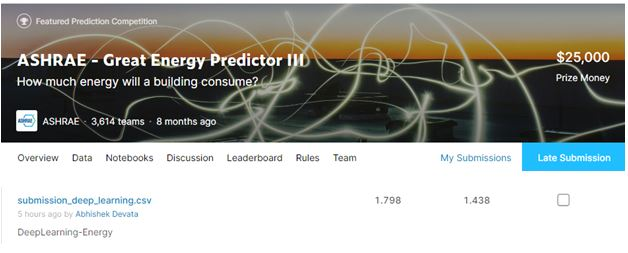

In [1]:
from IPython.display import Image
Image(filename='Capture1.JPG')     